# Intro to tensor flow
    - Load MNIST dataset
    - Linear model
    - Convolutional model

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


Tensorflow version:  0.11.0rc2


/Users/jorge/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jorge/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Get some data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


Train shape:  (55000, 784)
Valid shape:  (5000, 784)
Test  shape:  (10000, 784)


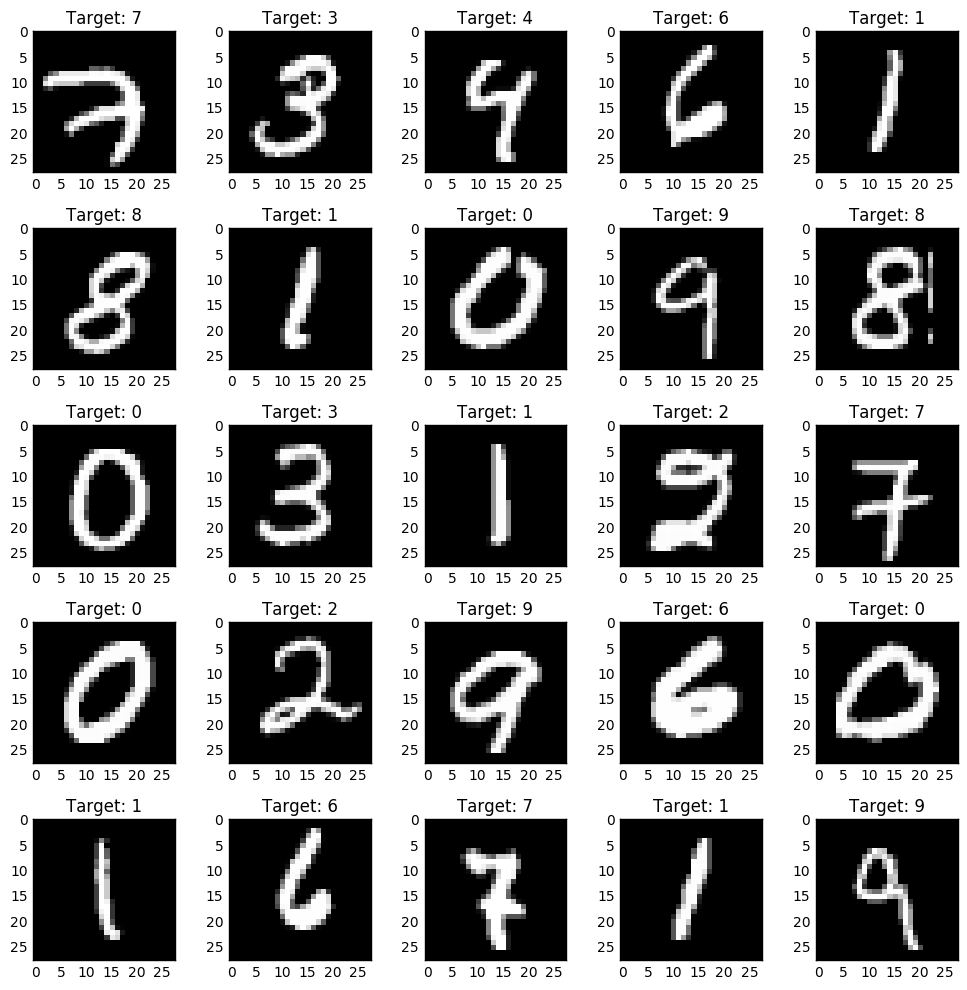

In [4]:
#Examine the data
print('Train shape: ', mnist.train.images.shape)
print('Valid shape: ', mnist.validation.images.shape)
print('Test  shape: ', mnist.test.images.shape)

fig = plt.figure()
for i in range(25):
    a = fig.add_subplot(5,5,i+1)
    a.set_title('Target: ' + str(np.argmax(mnist.train.labels[i])))
    fig.tight_layout()
    plt.imshow( np.reshape(mnist.train.images[i],(28,28)) )



## Linear model

In [5]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


### Define the graph

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y_pred = tf.nn.softmax(tf.matmul(x,W) + b)
#------------------------------------


# Loss
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))

# Trainer
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)


### Train the graph
# Intialize vars
sess.run(tf.initialize_all_variables())

# Iterate running the trainer
batch_size = 128
num_epoch = 50
for epoch in range(num_epoch):
    for i in range(430):  # 215 * batch_size is aprox the train size (55000)
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1]})

    
# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    

#When finish, close the interactive session
sess.close()

Test accuracy:  0.9259


## Neural network model

In [8]:
def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


### Define the graph

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
# First layer
dense_1 = dense_layer(x, input_dim=784, output_dim=500)

# Final layer
dense_2 = dense_layer(dense_1, input_dim=500, output_dim=10)
y_pred = tf.nn.softmax(dense_2)
#------------------------------------


# Loss
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))

# Trainer
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Train the graph
# Intialize vars
sess.run(tf.initialize_all_variables())


# Iterate running the trainer
batch_size = 128
num_epoch = 50
for epoch in range(num_epoch):
    for i in range(430):  # 430 * batch_size is aprox the train size (55000)
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1]})
    print('Epoch: ',epoch,' - Accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    

#When finish, close the interactive session
sess.close()

Epoch:  0  - Accuracy:  0.8473
Epoch:  1  - Accuracy:  0.9458
Epoch:  2  - Accuracy:  0.9556
Epoch:  3  - Accuracy:  0.9615
Epoch:  4  - Accuracy:  0.9632
Epoch:  5  - Accuracy:  0.9671
Epoch:  6  - Accuracy:  0.9707
Epoch:  7  - Accuracy:  0.9723
Epoch:  8  - Accuracy:  0.9723
Epoch:  9  - Accuracy:  0.9737
Epoch:  10  - Accuracy:  0.9752
Epoch:  11  - Accuracy:  0.9748
Epoch:  12  - Accuracy:  0.9759
Epoch:  13  - Accuracy:  0.9771
Epoch:  14  - Accuracy:  0.9763
Epoch:  15  - Accuracy:  0.9758
Epoch:  16  - Accuracy:  0.9765
Epoch:  17  - Accuracy:  0.9787
Epoch:  18  - Accuracy:  0.9784
Epoch:  19  - Accuracy:  0.9779
Epoch:  20  - Accuracy:  0.979
Epoch:  21  - Accuracy:  0.9803
Epoch:  22  - Accuracy:  0.9794
Epoch:  23  - Accuracy:  0.9794
Epoch:  24  - Accuracy:  0.9795
Epoch:  25  - Accuracy:  0.9805
Epoch:  26  - Accuracy:  0.9789
Epoch:  27  - Accuracy:  0.9797
Epoch:  28  - Accuracy:  0.9801
Epoch:  29  - Accuracy:  0.9799
Epoch:  30  - Accuracy:  0.9799
Epoch:  31  - Accur

## Convolutional model

In [18]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    return conv_out


def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

In [19]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
h_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 1: ', h_pool1)

#Second convolution
h_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv1')
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 2: ', h_pool2)

#First dense layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
print('Dense 1: ', h_fc1)

#Dropout over 
dropout_keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)

#Second dense layer
h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10)
print('Dense 2: ', h_fc2)

#Prediction
y_pred = tf.nn.softmax(h_fc2)
#------------------------------------


# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(h_fc2, y, name='cross_entropy')

#Optimizer
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

#Accuracy
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Conv - pool 1:  Tensor("MaxPool_2:0", shape=(?, 14, 14, 20), dtype=float32)
Conv - pool 2:  Tensor("MaxPool_3:0", shape=(?, 7, 7, 50), dtype=float32)
Dense 1:  Tensor("Relu_8:0", shape=(?, 500), dtype=float32)
Dense 2:  Tensor("Relu_9:0", shape=(?, 10), dtype=float32)


In [20]:
#Inicialization.
sess.run(tf.initialize_all_variables())

# Train proccess
for i in range(2000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1})
        print("step %d, training accuracy %g"%(i, train_accuracy))


step 0, training accuracy 0.1875
step 100, training accuracy 0.765625
step 200, training accuracy 0.960938
step 300, training accuracy 1
step 400, training accuracy 0.976562
step 500, training accuracy 0.976562
step 600, training accuracy 0.945312
step 700, training accuracy 0.992188
step 800, training accuracy 0.984375
step 900, training accuracy 1
step 1000, training accuracy 0.992188
step 1100, training accuracy 1
step 1200, training accuracy 0.976562
step 1300, training accuracy 0.992188
step 1400, training accuracy 0.992188
step 1500, training accuracy 1
step 1600, training accuracy 0.984375
step 1700, training accuracy 0.992188
step 1800, training accuracy 1
step 1900, training accuracy 0.992188


In [21]:
acc_test = 0
for i in range(200):
    batch = mnist.test.next_batch(50)
    acc_test += accuracy.eval(feed_dict = {x:batch[0], y: batch[1], dropout_keep_prob: 1.0})
print("test accuracy: ", acc_test/200.)

test accuracy:  0.992600003183


In [27]:
sess.close()

## Use tensorboard to show the net & the training process.
    - The same previous convolutional model with the commands that need tensorboard

Based on https://www.tensorflow.org/versions/r0.7/how_tos/summaries_and_tensorboard/index.html 

In [4]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/'   + name, mean)
        tf.scalar_summary('sttdev/' + name, tf.sqrt(tf.reduce_mean(tf.square(var - mean))))
        tf.scalar_summary('max/'    + name, tf.reduce_max(var))
        tf.scalar_summary('min/'    + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)


In [5]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    # Add summary ops to collect data
    variable_summaries(W_conv, "weights_"+name) #TENSORBOARD
    variable_summaries(b_conv, "biases_"+name) #TENSORBOARD
    return conv_out


def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    variable_summaries(W, "weights_"+name) #TENSORBOARD
    variable_summaries(b, "biases_"+name) #TENSORBOARD
    return dense_output

In [6]:

# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10] , name='y')



#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
# use a name scope to organize nodes in the graph visualizer
with tf.name_scope("conv1") as scope:
    h_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 1: ', h_pool1)
    # Add summary ops to collect data
    variable_summaries(h_pool1, "h_pool1_summary") #TENSORBOARD

#Second convolution
with tf.name_scope("conv2") as scope:
    h_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv2')
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 2: ', h_pool2)
    variable_summaries(h_pool2, "h_pool2_summary") #TENSORBOARD

#First dense layer
with tf.name_scope("dense1") as scope:
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
    h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
    variable_summaries(h_fc1, "dense1_summary") #TENSORBOARD

    #Dropout over 
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout')
    h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)
    
#Second dense layer
with tf.name_scope("dense2") as scope:
    h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10, name='dense2')
    print('Dense 2: ', h_fc2)
    variable_summaries(h_fc2, "dense2_summary") #TENSORBOARD

#Prediction
y_pred = tf.nn.softmax(h_fc2)



# Loss function
with tf.name_scope("xent") as scope:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(h_fc2, y, name='cross_entropy')
    ce_summ = tf.histogram_summary("cross entropy", cross_entropy) #TENSORBOARD


#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

#Accuracy
with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy) #TENSORBOARD


Conv - pool 1:  Tensor("conv1/MaxPool:0", shape=(?, 14, 14, 20), dtype=float32)
Conv - pool 2:  Tensor("conv2/MaxPool:0", shape=(?, 7, 7, 50), dtype=float32)
Dense 2:  Tensor("dense2/Relu:0", shape=(?, 10), dtype=float32)


In [11]:
# Merge all the summaries and write it into /tmp/tensorboard/mnist_logs
summaries_dir = '/tmp/tensorboard/mnist_conv'
with tf.name_scope('summaries') as scope:
    merged = tf.merge_all_summaries()
    train_writer = tf.train.SummaryWriter(summaries_dir + '/train', sess.graph)
    test_writer  = tf.train.SummaryWriter(summaries_dir + '/test')
    


In [12]:
#Inicialization.
sess.run(tf.initialize_all_variables())

# Train proccess
for i in range(1000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    
    if i % 10 == 0:  # Record summary data for one batch
        summary_str = merged.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1.})
        train_writer.add_summary(summary_str, i) #TENSORBOARD
        
        batch_test = mnist.test.next_batch(128)
        summary_str = merged.eval(feed_dict={x: batch_test[0], y: batch_test[1], dropout_keep_prob: 1.})
        test_writer.add_summary(summary_str, i) #TENSORBOARD
        

In [ ]:
sess.close()

At the end execute tensorboar with:

    cd /tmp

    tensorboard --logdir=./tensorboard

And accest to it in:

    http://localhost:6006


## Save and load models


In [1]:
# Create and save model

import tensorflow as tf

#Load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)

# Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

# Define graph
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


#Prediction
y_pred = tf.nn.softmax(tf.matmul(x,W) + b, name='y_pred')

#Loss
cross_entropy = -tf.reduce_sum(y*tf.log(y_pred), name='cross_entropy')

# Train graph
train_step = tf.train.GradientDescentOptimizer(0.01, name='train_step').minimize(cross_entropy)


# Inicialize graph vars
sess.run(tf.global_variables_initializer())
for i in range(100):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

print('cross_entropy test', cross_entropy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
print('Accuracy test', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))


# Create a saver and save weigths.
saver = tf.train.Saver(max_to_keep=0)
saver.save(sess, '/tmp/my-model',)


#Close session
sess.close()


Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
cross_entropy test 4099.91
Accuracy test 0.8834
INFO:tensorflow:/tmp/my-model is not in all_model_checkpoint_paths. Manually adding it.


In [2]:
# Load pretrained model and evaluate it

import tensorflow as tf

#Load data
data_path = '/home/jorge/data/training/tensorflow/'
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(data_path + 'MNIST_data', one_hot=True)

# Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

#Load model
new_saver = tf.train.import_meta_graph('/tmp/my-model.meta')
new_saver.restore(sess, '/tmp/my-model')

# Evaluate over the test data
print('cross_entropy test', cross_entropy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
print('Accuracy test', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

sess.close()

Extracting /home/jorge/data/training/tensorflow/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/jorge/data/training/tensorflow/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/jorge/data/training/tensorflow/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/jorge/data/training/tensorflow/MNIST_data/t10k-labels-idx1-ubyte.gz
cross_entropy test 4099.91
Accuracy test 0.8834
